Let us try declarative programming.

## Sec. 3.1 Encoder and Decoder Stacks

I believe `class MultiHeadedAttention(nn.Module)` in [here][1] is not correct. There are 3 * 8 = 24 linear maps. 

__NO__, I was wrong, the implementation there is efficient: the pre-attention mapping of all heads are computed together. 
Instead performing
$$
[bs \times n \times 512] \cdot [512 \times 64]
$$
8 times, the computation is done via an operation
$$
[bs \times n \times 512] \cdot [512 \times 512] 
$$ The result is arranged as
$$
[bs \times n \times (64, 64, ..., 64)]
$$
You can reshape it to
$$
[bs \times n \times 8 \times 64]
$$

[1]:http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention

In [97]:
import torch
import torch.nn as nn
import math

# Attention 机制

先说本算法的重点 (如果你急于知道如何从最原始的文本数据到达算法的核心，可以参阅下文 “Data” 一节，该章节可与这里的介绍并行阅读)：

在最核心的层面，处理的数据是 
- n 个输入样本，每个样本为一个向量。我们认为此向量表达了每个输入样本的“特点”。
- m 个参考样本，每个样本为两部分
    - 一个特征向量。我们认为此向量表达了每个参考样本的跟输入相关方面“特点”。
    - 一个输出向量。我们认为此向量表达了每个参考样本的我们感兴趣需要输出的“特点”。
    
具体比如说 $Q \in \mathbb{R}^{6 \times 16}$, $K \in \mathbb{R}^{8 \times 16}$， $V \in \mathbb{R}^{8 \times 64}$： $Q$ 表示 有 6 个输入样本，每个被表示为一个 16 维的向量。还有 8 个参考样本，每个参考样本有一个 16 维的（与输入样本同维度）特征向量用于查询，类似于一个 `dict` 里面的“键”（key，为矩阵$K$的一行），还有一个 64 维的向量表示这个参考样本对算法最终输出的贡献，类似于一个 `dict` 当中的“值”（value，为矩阵$V$的一行）。

Attention 这一步操作为每个输入样本计算得到一个输出的特征向量。下面考虑某个特定的输入样本，比方说在我们的例子里面一个 6 个样本的 mini-batch 中的第 3 个样本。这个输入的特征向量就是 $Q$ 矩阵中的第三行，一个 16 维向量 $q_3 \in \mathbb{R}^16$。（以下我们省略样本编号 3 这个下标，因为这个编号不影响我们讨论的操作，这些操作适用于所有的输入样本）

下面一步是做“查询”。引入这步运算的动机是比较清晰的：$q$ 与 每个参考样本的 $K$-特征向量做内积，用于衡量这个输入样本与各参考样本的相似程度。相似度更高的参考样本将贡献更多到最终的输出中（见下面的运算）。

下面我们看这步运算具体的例子：

In [90]:
Q = torch.rand(6, 16)
K = torch.rand(8, 16)
V = torch.rand(8, 64)

q = Q[3]
query_ref_similarity = torch.zeros(8)
for i in range(8):
    query_ref_similarity[i] = (q * K[i]).sum()
print(query_ref_similarity)

tensor([ 4.2618,  3.6949,  4.3126,  4.4321,  5.1312,  5.0123,  5.5642,
         3.3436])


为了让上面这些内积的值能够当作权重来使用，我们做一步 `softmax`。

In [93]:
weights = torch.nn.functional.softmax(query_ref_similarity, dim=0)
print(weights, weights.sum())

tensor([ 0.0807,  0.0458,  0.0849,  0.0957,  0.1926,  0.1710,  0.2970,
         0.0322]) tensor(1.)


那么我们现在确认得到了用于构建针对于 q 的输出的权重，下面要把这些权重组合到各个参考样本的“值”，$V$-特征向量去:

In [96]:
v = torch.zeros(64)
for i in range(8):
    v += weights[i] * V[i]
print(v.shape)

torch.Size([64])


可以看出对于作为例子的这个特定的$q$，我们得到了一个64维的输出。把上面的算法总结一下，将其中的循环相加用简洁的矩阵相乘表示。

- 对 $Q$ 的每行都计算它们与 $K$ 的行向量的内积：$S \leftarrow Q\cdot K^T, S \in \mathbb{R}$，则 $S$ 的每行代表 $Q$ 相应的行与每个 $K$-特征向量的内积，$S$ 的一行中含有的元素个数等于 $K$-特征向量的个数（$K$ 的行数）。

- 使用上面求得的 $S$ 的每一行组合 $V$：$Y \leftarrow \hat{S} \cdot V$. 其中 $\hat{S}$ 是把 $S$ 的每一行元素都做 softmax 的结果。

我们定义 attention 函数运算如下：

In [98]:
def attention(q, k, v, mask=None, dropout=None):
    """
    Perform scaled dot-project attention as in Fig. 1
    :param q:query keys, [... x #.query-keys x features]
    :param k:referece keys, [... x #.reference-keys x features]
    :param v:
    :param mask: #.query-keys x #.reference-keys
    :param dropout: functional x -> dropout(x)
    """
    key_feats = q.shape[-1]
    
    qm = torch.matmul(q, k.transpose(-2, -1)) \
        / math.sqrt(key_feats)
    if mask is not None:
        qm = qm.masked_fill(mask==0, 1e-9)
    qm = nn.functional.softmax(qm, dim=-1)
    if dropout is not None:
        qm = dropout(qm)
    out = torch.matmul(qm, v)
    return out, qm

需注意三点：
- 运算可以针对整个 mini-batch 即若干个输入文档和若干个输出文档一起操作
- 我们使用了一个常数乘子来抵消 query-key 的维数的影响，比如 $q$-向量如果是16维，则它与每个$K$-向量的内积就会被除以 $\sqrt(16)=4$.
- 可以用 mask 把某些特定的参考样本给去除，方法是 `qm.masked_fill(mask==0, 1e-9)` -- 而这个操作是可以 “broadcast” 的，即可以为每一个文档都指定某种忽略参考向量的模式（broadcast in dim-0），也可以为每一个输出向量指定某种忽略参考向量的模式broadcast in dim-1）（参见下面的例子）

In [102]:
tmp = torch.rand(3, 4, 5)
tmp.masked_fill(torch.ByteTensor([True, True, False, True, False]), 0.6)

tensor([[[ 0.6000,  0.6000,  0.4853,  0.6000,  0.1479],
         [ 0.6000,  0.6000,  0.6270,  0.6000,  0.3562],
         [ 0.6000,  0.6000,  0.9705,  0.6000,  0.4837],
         [ 0.6000,  0.6000,  0.9913,  0.6000,  0.6537]],

        [[ 0.6000,  0.6000,  0.6504,  0.6000,  0.6455],
         [ 0.6000,  0.6000,  0.9872,  0.6000,  0.1887],
         [ 0.6000,  0.6000,  0.6267,  0.6000,  0.2098],
         [ 0.6000,  0.6000,  0.1678,  0.6000,  0.6016]],

        [[ 0.6000,  0.6000,  0.7557,  0.6000,  0.4532],
         [ 0.6000,  0.6000,  0.9578,  0.6000,  0.2066],
         [ 0.6000,  0.6000,  0.7310,  0.6000,  0.6122],
         [ 0.6000,  0.6000,  0.0100,  0.6000,  0.4547]]])

In [14]:
class AttentionLayer(nn.Module):
    def __init__(self, in_features, attention_heads,
                 dropout=0.1):
        """
        :param in_features: the dim of word representation, e.g. 512
        :param attention_heads: attention "heads", e.g. 8
        :param dropout:
        """
        super(AttentionLayer, self).__init__()
        assert in_features % attention_heads == 0
        
        self.in_features = in_features
        self.proj_features = in_features // attention_heads  # the dim of projected 
            # keys and values in multi-head attention e.g. 64
        self.attention_heads = attention_heads
        if dropout is not None:
            self.dropout = nn.Dropout(p=dropout)
        # in_features = #.heads * proj_features_per_head
        # = out_features
        self.q_projs = nn.Linear(in_features, in_features)     
        self.k_projs = nn.Linear(in_features, in_features)
        self.v_projs = nn.Linear(in_features, in_features)
        self.final_proj = nn.Linear(in_feature, in_features)
        self.attn = None
    
    def forward(self, query_keys, ref_keys, ref_values, mask=None):
        """
        :param query_keys: [batch_size, n, feat_dim]
          batch_size: number of documents
          n: number of words in each document
          feat_dim: number of features of embedded word
        :param ref_keys:
        :param ref_values:
        :param mask: if attention layer is auto-regressive -- position i, can only
          refer to positions 0..i-1
        """
        batch_size = query_keys.shape[0]
        
        if mask is not None:
            # mask is of [batch-size, n, n] it is different for each document
            # because paddings for non-valid words
            # so you cannot simply "broadcasting" is using the last [n, n] slice
            mask = mask.unsqueeze(1)
        
        q, r, v = [f(x)
                   .reshape(batch_size, -1, 
                            self.attention_heads, 
                            self.proj_features)
                   .transpose(1, 2) 
                   for f, x in zip([self.q_projs, self.k_projs, self.v_projs],
                                   [query_keys, ref_keys, ref_values])]
                   
            

        a, self.attn = attention(q, r, v, mask, self.dropout)
        a = a.transpose(1, 2)\
             .reshape(batch_size, -1, self.in_features)
        y = self.final_proj(a)

        return y
        

In [ ]:
batch_size = 32
n = 20
m = 25
feat_num = 512
multi_attention_feat_dim = 64
x = torch.rand(batch_size, n, feat_num) # encoder
y = torch.rand(batch_size, m, feat_num)
query_keys = y
ref_keys = ref_values = x
# making mask
# -inf doesn't work for position 1, which has no previous position to attend
mask = (torch.zeros(n, n)).triu()
anet = AttentionLayer(512, 8)

In [ ]:
codec = anet(query_keys, ref_keys, ref_values)
print(codec.shape)

In [ ]:
enc = anet(x, x, x, mask)
print(codec.shape)

In [ ]:
%debug

I use the new feature of reshaping but the old implementation use view on contiguous memory.

In [ ]:
# b1 = codec.transpose(1, 2).view(32, 25, 512) -- cause error
b1a = codec.transpose(1, 2).contiguous().view(32, 25, 512)
b2 = codec.transpose(1, 2).reshape(32, 25, 512)
(b2 - b1a).abs().max()

In [ ]:
feat_num=512
feat_num_a=64
num_attn=8
qproj = nn.Linear(in_features=feat_num,
                  out_features=feat_num_a*num_attn)

In [ ]:
q = qproj(query_keys)\
    .reshape(batch_size, -1, num_attn, feat_num_a)\
    .transpose(1, 2)
print(q.shape)
q.masked_fill()

In [ ]:
q = torch.rand(3, 2, 4, 5)
mask = torch.rand(4, 5)>0.5

In [ ]:
q.masked_fill(mask, 999)

In [ ]:
def EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y
    
def Encoder(nn.Module):
    def __init__(self, encoder_layer_factory, n_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([_ for _ in encoder_layer_factory])
        
    def forward(self, x):
        for ly in self.layers:
            x = ly(x)
        return x
    
def EncoderLayer(nn.Module):
    def __init__(self, n_feat, attention_layer_factory):
        """
        :param attention_layer_factory: 
        """
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm([512,])
        self.sublayer  = attention_layer_factory(n_feat)
        
    def forward(self, x):
        return self.layernorm( x + self.sublayer(x) )

# Data

数据来源是 IWSLT 英德翻译任务，该项任务是自然语言处理的常用测试，其数据集是 torchtext 工具包自带的。需要的工具 `torchtext`, `spacy`

- `pip install torchtext spacy`

## 预处理
spacy 是做预处理工作的，我们需要下载它针对英语和德语的语法数据库来帮助处理数据（tokenize，把原始文本处理成如解释缩写，处理单词的不同形式）

In [28]:
import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

这样我们就有了两个语言处理器，分别对付英语和德语。让我们试一下将要用到的功能。

In [29]:
raw_text = "A fox is jumping over 12 boxes."
tk = spacy_en(raw_text)
print(tk)
for t in tk:
    print(t)

A fox is jumping over 12 boxes.
A
fox
is
jumping
over
12
boxes
.


这里看上去就是把一个句子的每个单词都分开来了，“似乎没有什么特别的嘛”——我们应该这样感觉吧。比如把空格符当作分割的标记，不是可以轻易完成这项工作吗？但是请注意这里一个细节，它把句点`.`成功滴分割成了一个 token，这不是可以简单用空格来分割而做到的。也许你还会想，这样也还好，我们把数字字母构成的字符串分开来就可以了。但是这项工作比你想象的要难得多。从广泛意义上，这里需要规定怎样的一个语言单元可以算作一个token。比如上面那句话如果这样写：

In [30]:
raw_text = "A fox's jumping over 12 boxes."
tk = spacy_en(raw_text)
print(tk)
for t in tk:
    print(t, ':', t.pos_, t.pos, t.lemma_)

A fox's jumping over 12 boxes.
A : DET 89 a
fox : NOUN 91 fox
's : VERB 99 be
jumping : VERB 99 jump
over : ADP 84 over
12 : NUM 92 12
boxes : NOUN 91 box
. : PUNCT 96 .


In [31]:
tk = spacy_en.tokenizer("A fox's jumping over 12 boxes.")
for t in tk:
    print(t, ':', t.pos_, t.pos, t.lemma_)

A :  0 A
fox :  0 fox
's :  0 have
jumping :  0 jump
over :  0 over
12 :  0 12
boxes :  0 box
. :  0 .


注意它把`'s`识别成它的原型`be`。而且每个处理过的单词——现在是一个Token对象——。以这些更加规整的元素为基础，我们就可以进行自然语言处理了。注意在下面的例子中，为了速度起见，我们使用底层的第一级处理 tokenizer，而不做nlp的分析（本来我们就要进行这部分工作）。

In [ ]:
def tokenizer_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenizer_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

## 构造训练数据流

我们当然可以把训练数据中的每一对英德文档都用上面的tokenizer预处理一遍，然后把所得的tokens重新保存成两堆互相一一对应的英德token集合。但是这样非但浪费空间，而且牺牲了灵活性，使得将来做试验时更换其它预处理的方法和参数的操作非常笨拙不便。torchtext 提供一个方便的框架，使得我们在真正的训练步骤开始之前（就数据而言，即为它被真正被读入内存）只需要描述当文档数据到来时，我们“打算”如何处理。

In [ ]:
from torchtext import data, datasets
BLANK_WORD = "<blank>"
BOS_WORD = "<s>"
EOS_WORD = "</s>"
SRC = data.Field(tokenize=tokenizer_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenizer_en, init_token=BOS_WORD,
                 eos_token=EOS_WORD, pad_token=BLANK_WORD)

`data.Field` 是专门用于某一类数据的处理器件，对应于数据集中的一个变量。如果我们把数据想象成一个大表格，每个数据样本是一行，每种属性是一列。对于双语翻译的数据集来说，每个样本（行）就是源语言和目标语言的两篇文档。 分别占据两列，表格的一列就是一种语言。那么一个Field对象也就描述了针对一种语言的文档的处理方式。

```
Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

If a Field is shared between two columns in a dataset (e.g., question and answer in a QA dataset), then they will have a shared vocabulary.
```

在上面的例子里面……

In [5]:
import os
DATA_PATH_ROOT = os.path.expanduser("~/data/common/nlp")
MAX_LEN = 100
def doc_length_filter(data_item):
    good = len(vars(data_item)['src']) <= MAX_LEN \
        and len(vars(data_item)['trg']) <= MAX_LEN
    return good

train, val, test = datasets.IWSLT.splits(
    root=DATA_PATH_ROOT,
    exts=('.de', '.en'),
    fields=(SRC, TGT),
    filter_pred=doc_length_filter)

In [ ]:
for doc_pair in train:
    break
print("Type of a data sample", type(doc_pair))
print("docs.src", doc_pair.src)
print("docs.trg", doc_pair.trg)

splits 返回三个子集对应于train validatiaon和test。注意这里的划分是从上述的“数据表格”的行的角度来看的，每个子集都是若干行，每行都包含了两类不同的文本（注意有的情况下test集合里面没有目标文本）。
- root：数据下载和保存的文件夹如果是第一次使用，下载之
- exts=('.de', '.en')：指明每个样本当中的文档对里面的两种语言的文档的扩展名（这样的设置是针对本数据集的，其它数据集可能有不同的存储方式，比如不用扩展名而是以JSON文件中的域来存储不同类型的文档）。
- fields=(SRC, TGT)：用上面定义的两个预处理器来处理两类文档
- filter_pred=doc_length_filter：为了效率起见，我们只返回不超过一定长度的文本。

下面把这样的文本转换成一系列整数。分别对应于每个 token 在英语/德语 token 集合中的唯一索引。你可以想象一下，比方说我们想处理英文文档，比方说使用用英语通讯，但是每次发送一个单词非常浪费和不安全。于是我们把英语中常用的单词和其它的有用的语言符号，比如据点，逗号都编纂成一部字典。然后我们就可以用一串整数来表示一个文档了。在双语分析这个特定的问题上，这步处理可以分别对源和目标语言来做，也可以合并编纂一整个双语字典（比方说这样就可以共享句点这类token）。无论如何，我们首先把英语和德语中用到的tokens收集起来。这可以分别交给两个 Field 对象方便的实现。

In [33]:
MIN_FREQ = 2
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

文档数据有个特点，每个数据样本的长度都是变化的。我们的模型里面，数据的长度是三维 tensor 的第二个维度（分别是：1 mini-batch 中数据样本，即成对的源/目标文档的数量；2 每个数据中的源文档的长度（token数）；3 每个token 被 embed 的子空间维度）。其中1 是灵活的，我们可以随便根据硬件和其它情况设置每一步训练使用多少个样本。3是全局统一的一个变量。问题出在2，同一个mini-batch中的每个源文档的token数必须一致。这显然不符合现实。但是如果不能把每个源文档组织成一致的长度，我们就只能一步训练使用一个数据样本，效率太低。所以我们折衷：我们把一个mini-batch里面所有的文档都填充成为一样大小。显然对于这个操作而言，如果我们能把本来长度就相似的文档组织到一起，需要填充的无效token就越少，运算效率也高。

torchtext.data 提供了 batch 组织的方式。下面的方法是一次读入更多的data（100倍batch大小）然后让data的排序等操作在这个大缓冲区当中进行，可以让读到的文本集更加规整。近一步减少填充。

In [10]:
class MyIterator(data.Iterator):
    def __init__(self, database, batch_size, **kwargs):
        super(MyIterator, self).__init__(database, batch_size, **kwargs)
        # will call my create_batches
    
    def create_batches(self):
        """
        "Pre-fetch" 100x batch-size samples, to cluster the similarly sized.
        ones together.
        
        This is an overload function. It will be called when we "connect" to data.
        """
        # print("My iterator connected to data ...")
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size*100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, 
                        self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
        else:
            print("test")
            self.batches = []
            for b in data.batch(self.data(), 
                                self.batch_size, 
                                self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

把我们的 MyIterator 跟 train data 连起来试试。注意 MyIterator 里面的 `batch` 在任何情况下都是个generator。注意可以在上面代码的打印“Connected to data”那里输出更多的信息。

[一张图说明 Iterator -> Dataset -> Field]的功能性依存关系。

In [49]:
myiter = MyIterator(train, batch_size=20, 
                    sort_key=lambda x: (len(x.src), len(x.trg)))
batch = next(iter(myiter))
print(batch)
for i in range(2):
    src_doc = [ti_.item() for ti_ in batch.src[i]]
    trg_doc = [ti_.item() for ti_ in batch.trg[i]]
    print("Doc [{:2d}]".format(i))
    print("\tsrc:", src_doc)
    print("\ttrg:", trg_doc)


[torchtext.data.batch.Batch of size 20 from IWSLT]
	[.src]:[torch.LongTensor of size 7x20]
	[.trg]:[torch.LongTensor of size 12x20]
Doc [ 0]
	src: [16186, 475, 3947, 15, 22, 39, 681, 2861, 25, 37, 348, 105, 44, 22, 14, 10815, 15008, 8502, 61, 140]
	trg: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Doc [ 1]
	src: [2449, 111, 851, 18, 73, 7, 7, 572, 154, 7, 2, 92, 50, 11, 3347, 7, 1715, 30, 8, 335]
	trg: [16850, 599, 7418, 12105, 19, 51, 850, 1142, 12, 92, 699, 1142, 58, 19, 45, 105, 4079, 58, 59, 247]


数据的样子大致如此，上面的例子里面src是 $16\times 20$ 的 tensor。也就是20个文档，每个包含 16个 tokens。注意我们需要的是 mini-batch $\times$ #.tokens 这样的形式。更重要的是，我们要把这批（mini-batch）文档哪里是被填充的地方标记出来。后面的 attention 运算中要略过。所以要再处理一次。 注意我们首先要得到用于填充的那个token的编号。另外我们给出一个构造 `subsequent_mask`的方法，该 mask 使得 attention 运算时某个位置的 token 只与其之前的 tokens （以及自身） 关联。本质上是一个 $n \times n$ 的下三角矩阵。$n$ 是这个batch里面每个文档包含的token的数量。

mask 的形式应该是 mini-batches $ \times n \times n $。

In [35]:
pad_idx = TGT.vocab.stoi[BLANK_WORD]
assert pad_idx == SRC.vocab.stoi[BLANK_WORD]
print(pad_idx)

1


In [ ]:
def subsequent_mask(s):
    """
    Mask out subsequent positions
    """
    return (torch.ones(s, s).triu(1)<0.5).unsqueeze(0)

# Batch and masking        
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        # mask used by decoder, it needs to heed everywhere
        # which is not padded in the source document.
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask \
            & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask
    
def rebatch(pad_idx, batch):
    """
    adjust the 
    """
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0,1)
    return Batch(src, trg, pad_idx)

In [54]:
in_batch = rebatch(pad_idx, batch)
print("src-mask is of ", in_batch.src_mask.shape)
print("trg-mask is of ", in_batch.trg_mask.shape)

for i in range(2):
    
    src_doc = [ti_.item() for ti_ in in_batch.src[i]]
    trg_doc = [ti_.item() for ti_ in in_batch.trg[i]]
    print("Doc [{:2d}]".format(i))
    print("\tsrc:", src_doc)
    print("\ttrg:", trg_doc)
    print("\tsrc_mask:", in_batch.src_mask[0].squeeze())
    print("\ttrg_mask:\n", in_batch.trg_mask[0])

src-mask is of  torch.Size([20, 1, 7])
trg-mask is of  torch.Size([20, 11, 11])
Doc [ 0]
	src: [16186, 2449, 8, 615, 1061, 59, 3]
	trg: [2, 16850, 4, 3257, 750, 1390, 40, 6, 91, 5, 3]
	src_mask: tensor([ 1,  1,  1,  1,  1,  1,  1], dtype=torch.uint8)
	trg_mask
: tensor([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]], dtype=torch.uint8)
Doc [ 1]
	src: [475, 111, 1631, 20, 11465, 30, 32]
	trg: [2, 599, 16, 72, 84, 1651, 78, 34, 2595, 31, 3]
	src_mask: tensor(

上面的`.unsqueeze(-2)` 是说这个 mask 会 broadcast 到倒数第二个维度。在计算attention的时候：$ K^T V \cdot M_{src}$ 倒数第二维是每个 token，也即是说对每个decoding阶段的 token 来说，回头去跟input tokens寻找联系的方式都是一样的 —— 跟所有的非填充的input tokens联系。注意这个 mask 在不同的文档间是不一样的，因为填充方式一般不同。所以第一个维度正好是mini-batch的大小。

而 trg_mask 代表语言向前产生式的 mask，这对每个 token 都是不一样的。就这个要求来说，对每个文档虽然是一样的，但是其填充的方式却又不同，所以只要全部都列上——其实我觉得有可能可以在做 attention 运算的时候执行两次 mask 操作，一次是对每个文档都一样的 subsequent_masking, 一次是对每个文档分别执行，但是对每个token都一样的去除填充的tokens。

## 第一步的数据表示
第一步是embedding，即把每个 token 用一个512维向量表示。这一步其实是一个稀疏的线性映射。

In [18]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, emb_dim)
        self.k_ = math.sqrt(emb_dim) # following arxiv.1608.05859
        
    def forward(self, x):
        return self.lut(x) * self.k_
    
emb_layer = Embeddings(len(SRC.vocab), 512)

我们尝试把上面第一个 mini-batch 中的 src 文档用这个 `emd_layer` 处理一下。

In [57]:
x = emb_layer(in_batch.src)
print(x.shape)

torch.Size([20, 7, 512])


结果是 20 个文档，每个文档 7 个 token，每个 token 表示为一个 512 维的向量。

## 把位置信息合并进入数据的表示

在自然语言中，每个 token （比如单词） 在一句话当中的位置能影响其代表的含义。[example]。所以我们引入一个机制，使得同一个单词在不同位置出现的时候，其编码有所不同。注意在上一步处理过后，每个单词都对应于一个512维的实数值向量。原文还讨论了不少[相关的信息][1]。

这里使用的具体方法是引入一个 “positional embedding” (PE) 向量（与原 embedding 同样的格式，512维，最终会加起来）。这个 PE 分作两部分，各256维。分别是256个不同波长的 $sin$ 和 $cos$ 信号。
$$
V^{PE}_{2i}(p) = \sin(\frac{p}{10000^{ \frac{2i}{512} }})
$$
奇数维 $V^{PE}_{2i+1}$ 就是把上面的 $\sin$ 换成 $\cos$. 

考虑 PE 整个文档的结果是一个矩阵 $n \times 512$, n=#.tokens。这里的 $i = [1..256]$ 就是“横穿”每一行的下标 (注意我们用$2i$ 和 $2i+1$)，表示不同的 embed 维度，$p = [1..n]$ 是纵贯每一列的下标，表示每个 token。也即是每个 token 的位置被表示成 512 个实数值，越往后的维度，分母越大，波形变化越慢，越表示对位置不敏感的那些语义。反之，前面的维度对位置敏感，表示的含义与该单词在句子中的位置密切相关。


[1]:https://arxiv.org/1705.03122.

In [75]:
class PositionalEncoding(nn.Module):
    def __init__(self, d, dropout=0.1, max_len=5000):
        """
        :param d: embed dimension
        """
        super(PositionalEncoding, self).__init__()
        self.dropout_layer = nn.Dropout(dropout)
        
        # cache enough PE for max_len
        pe = torch.zeros(max_len, d)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d, 2)/d*math.log(10000))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x
        

In [86]:
# Explore the construction of the coefficient matrix
print(torch.arange(5).unsqueeze(1) \
    * torch.exp(-torch.arange(0, 512, 64)/512*math.log(10000)))

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 1.0000,  0.3162,  0.1000,  0.0316,  0.0100,  0.0032,  0.0010,
          0.0003],
        [ 2.0000,  0.6325,  0.2000,  0.0632,  0.0200,  0.0063,  0.0020,
          0.0006],
        [ 3.0000,  0.9487,  0.3000,  0.0949,  0.0300,  0.0095,  0.0030,
          0.0009],
        [ 4.0000,  1.2649,  0.4000,  0.1265,  0.0400,  0.0126,  0.0040,
          0.0013]])


注意在 `x + self.pe[:, :x.shape[1]]` 里面 `[:, ...]` 第一个冒号是为了保留住上面构造 `pe` 的时候特意扩展出来的对应于 sample in mini-batch 的那个维度。


注意这个量需要仔细地画图出来检查一下。我第一次实现时带入了一个 bug，在 
```
div_term = torch.exp(-torch.arange(0, d, 2)/d*math.log(10000))
```
中漏掉了 `exp(-...)` 中的符号，导致数据形式完全正确，但是在所有的维度上都变化非常剧烈 —— 相当于 `sin` 的频率十分大，大部分维度上甚至大到 `position + 1` 就会跨越超过一个周期，这就失去了这个量作为positional encoding的意义。而单纯的成为噪音。

PE这步操作如果对训练有证明的影响，把这项信息设置成了噪音就会降低 __任何__ 方法的表现。而且不可能
通过调参数来改善。会对研究和工程造成很大的困扰。

torch.Size([1, 5000, 512])


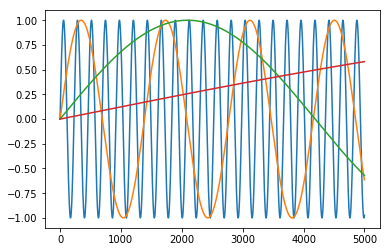

In [83]:
pe_layer = PositionalEncoding(512)
print(pe_layer.pe.shape)

import matplotlib.pyplot as plt
%matplotlib inline
plt.clf()
for i in range(200, 501, 100):
    plt.plot(pe_layer.pe[0][:, i].numpy())
plt.show()

下面我们试用这样一个位置信息编码器处理上面得到的输入`x`。

In [85]:
x1 = pe_layer(x)
print(x1.shape)

torch.Size([20, 7, 512])


IDEA：看看那个更细小的拆分token（用音节）的工作，如果试图用语言描述图像，限制传输的信息容量。会不会自动产生语言。

# Glossary
- tensor
- token
- embed
- mini-batch
